## Bayesian Optimization with Custom Objectives
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on
custom objectives. In this case, we develop models of individual components of the
objective function and combine samples from these models to calculate predicted
objective values.

In this example we try to maximize the objective function
$$f(g_1(x),g_2(x)) = \min(g_1(x), g_2(x))$$ where $g_1(x) = (x-0.5)^2$ and $g_2(x) =
(x - 2)^2$.


## Define the test problem

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0.0, 2.0]},
    observables=["g1","g2"]
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    return {"g1": (input_dict["x"])**2, "g2":(input_dict["x"]-2.0)**2}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.


            Xopt
________________________________
Version: 0+untagged.1.gac5c9b5
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.sin_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives: {}
  observables

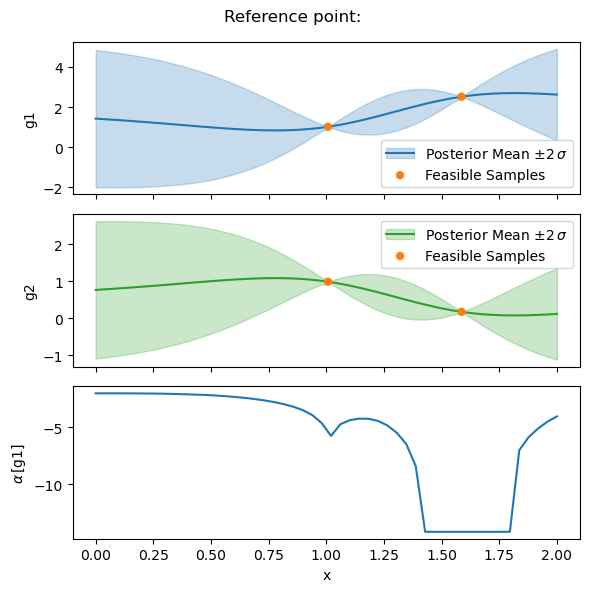

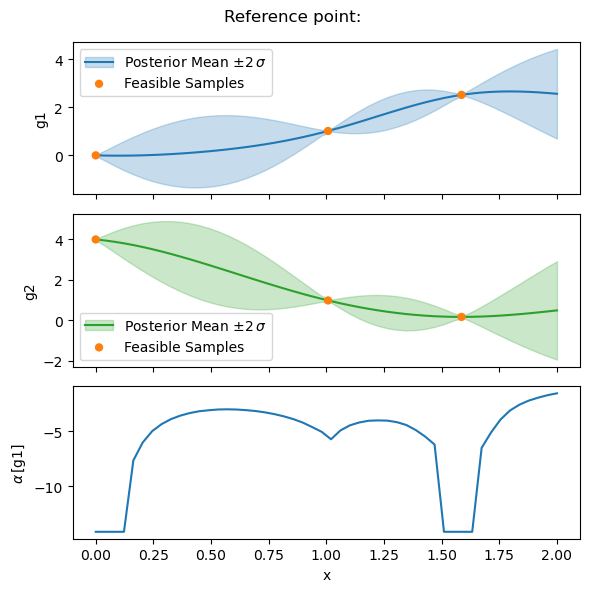

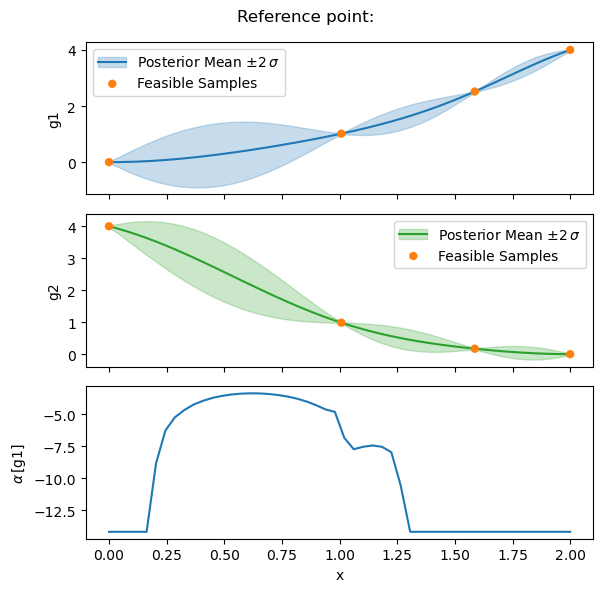

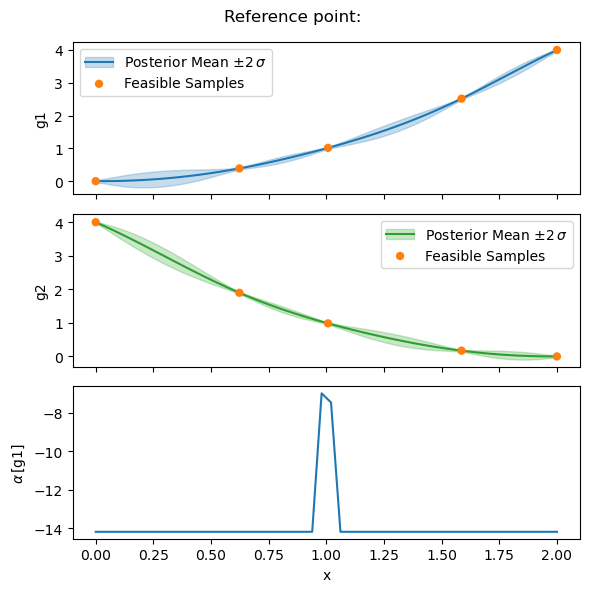

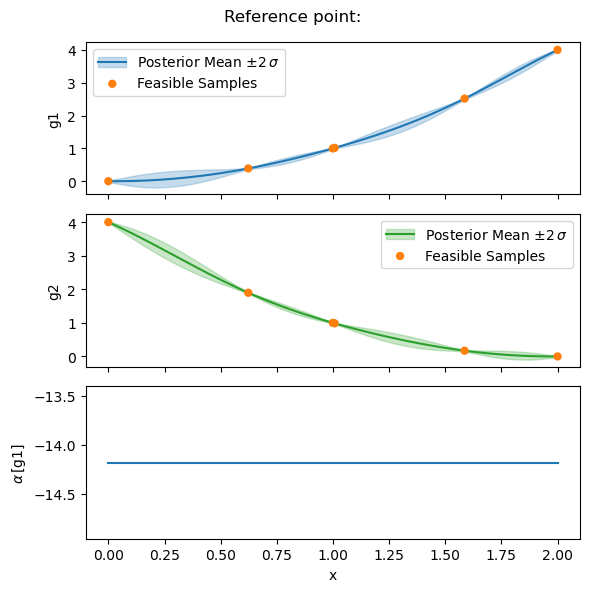

In [3]:
import torch
import matplotlib.pyplot as plt

from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt
from xopt.generators.bayesian.objectives import CustomXoptObjective
from torch import Tensor
from typing import Optional

class MyObjective(CustomXoptObjective):
    def forward(self, samples: Tensor, X: Optional[Tensor] = None) -> Tensor:
        return torch.min(samples[
            ..., self.vocs.output_names.index("g1")
        ], samples[
            ..., self.vocs.output_names.index("g2")
        ])

evaluator = Evaluator(function=sin_function)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    custom_objective=MyObjective(vocs),
    log_transform_acquisition_function=True
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
print(X)

X.random_evaluate(2)

n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    X.generator.visualize_model()

    # do the optimization step
    X.step()

In [4]:
# access the collected data
X.data

,x,g1,g2,xopt_runtime,xopt_error
0,1.586245,2.516174,0.171193,0.000004,False
1,1.007546,1.015149,0.984965,0.000001,False
2,0.000000,0.000000,4.000000,0.000004,False
3,2.000000,4.000000,0.000000,0.000003,False
4,0.622898,0.388002,1.896409,0.000004,False
5,0.999582,0.999165,1.000835,0.000004,False
6,1.000005,1.000011,0.999989,0.000004,False


## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [5]:
X.generator.get_optimum()

,x
0,0.999946


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [6]:
X.generator.dict()

{'model': ModelListGP(
   (models): ModuleList(
     (0-1): 2 x SingleTaskGP(
       (likelihood): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
       (mean_module): ConstantMean()
       (covar_module): ScaleKernel(
         (base_kernel): MaternKernel(
           (lengthscale_prior): GammaPrior()
           (raw_lengthscale_constraint): Positive()
         )
         (outputscale_prior): GammaPrior()
         (raw_outputscale_constraint): Positive()
       )
       (outcome_transform): Standardize()
       (input_transform): Normalize()
     )
   )
   (likelihood): LikelihoodList(
     (likelihoods): ModuleList(
       (0-1): 2 x GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
     )
   )
 ),
 'n_monte_carlo_samples': 1